In [1]:
if "descended" not in locals():
    descended = 1
    %cd ".."
    
import utils

import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle

from simulations import lightcurve_simulation as lcsim
import visualize as vis

/Users/Yke/Desktop/AI/Thesis/ESA/transit-detection-rnn


In [21]:
time, flux, masks, paramss = lcsim.get_lightcurve(2,2,t_max=5, rdepth_range=(2,10))


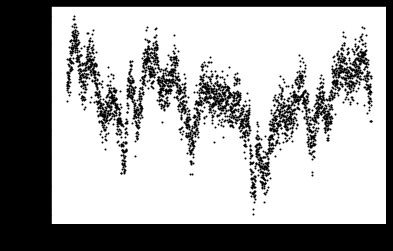

In [22]:
plt.figure(facecolor="black")
vis.plot(time, flux)

In [ ]:
def plot_results(dic, m, rng=(), split="valid", lbl="", linestyle="-", fill=True, return_c=True, c=None):
    x = np.arange(len(dic["mean"]["metrics"]["train"][()]["acc"]))
    p = plt.plot(x, dic["mean"]["metrics"][split][rng][m], linestyle=linestyle, label=lbl, color=c)
    if fill:
        plt.fill_between(x, dic["mean"]["metrics"][split][rng][m]-dic["std"]["metrics"][split][rng][m],
                        dic["mean"]["metrics"][split][rng][m]+dic["std"]["metrics"][split][rng][m], alpha=0.3, color=p[0].get_color())
    return p[0].get_color() if return_c else None

In [ ]:
mnames = list(np.unique(["_".join(f.split("_")[:-1]) for f in os.listdir("results/training")]))
mnames

In [ ]:
# load training results 

results = {1500:{}, 500:{}}
for N in results:
    for mname in mnames:
        fname = mname + "_sim.pkl" if N==1500 else mname + "_sim500.pkl"
        try:
            with open("results/training/"+fname, "rb") as f:
                results[N][mname] = pickle.load(f)
        except FileNotFoundError:
            print('"'+fname+'"', "not found")
        except:
            raise

## Identification

Given an input light curve segment, the task is to classify it as signal or non-signal. 

In [ ]:
# dontshow=["cnn", "mlp", "gru1", "bigru2", "bilstm1", "rnn_naive", "bigru1_w12.6"]
dontshow=[]
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
for mname in [m for m in mnames if m not in dontshow]:
    plot_results(results[1500][mname], "acc_seg", split="valid", lbl=mname, fill=0)
plt.legend(fontsize=12, bbox_to_anchor=(1,1))

plt.subplot(1,2,2)
for mname in [m for m in mnames if m not in dontshow]:
    try:
        plot_results(results[500][mname], "acc_seg", split="valid", lbl=mname, fill=0)
    except:
        pass
plt.legend(fontsize=12)
plt.tight_layout()
plt.show() 

## Detection
Given an input light curve (segment), the task is to locate signals in time.

#### Application to full-length light curves

In [ ]:
def detect(model, flux):
    flux_tens = torch.tensor(flux.reshape(1,-1)).type(torch.FloatTensor)
    with torch.no_grad():
        sigm, _ = model(flux_tens)
    return sigm.squeeze()

In [ ]:
rnn = torch.load("models/bigru1_sim.pt")

In [ ]:
np.random.seed(42)
lc = lcsim.get_lightcurve(num_planets=2, min_transits=2, period_range=(2,100), t_max=27.4, 
                          max_attempts=4, max_snr_attempts=10, snr_range=(3,80), 
                          rdepth_range=(.5,5.), dur_range=(0,utils.hour2day(14)))
time, flux, pl_masks, params = lc
pl1, pl2 = pl_masks[0], pl_masks[1]
nontr = ~np.any(pl_masks, 0)

In [ ]:
flux_ = (flux-1) / params["sigma"] / 2
sigm = detect(rnn, flux_)

In [ ]:
plt.figure(figsize=(15,3))
plt.subplot(2,1,1)
vis.plot(time[nontr], flux[nontr], c="black", a=0.1)
for msk in pl_masks:
    vis.plot(time[msk], flux[msk], c=plt.plot([])[0].get_color(), a=1)
plt.xlim(0,time[-1])

plt.subplot(2,1,2)
vis.plot(time, sigm, scatter=0)
plt.xlim(0,time[-1])

#### Training different network architectures

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
for mname in ["bigru1"]:
    c = plot_results(results[1500][mname], "tpr", split="valid", lbl=mname, fill=0, return_c=1)
    for rng in list(results[1500][mname]["mean"]["metrics"]["valid"].keys())[1:]:
         plot_results(results[1500][mname], "tpr", split="valid", lbl=rng, fill=0, c=c, rng=rng)
plt.legend()